In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
global window_size, alpha, threshold
alpha = 0.01
window_size = 3
threshold = 0.1

In [3]:
image=cv2.imread("./image4.jpg")/255
image=image[:,:,::-1]

In [4]:
def gaussianFilter(sigma,size):
    a=np.zeros((size,size))
    val=size>>1
    for i in range(size):
        for j in range(size):
            x,y=i-val,j-val
            a[i][j]=getGaussianValue(x,y,sigma)
    return a/np.sum(a)

In [5]:
def getGaussianValue(x,y,sigma):
    exp=-1*((x*x + y*y)/(2*sigma*sigma))
    val=np.power(np.e,exp)
    return val/(2*np.pi*sigma*sigma)

In [6]:
def padding(image,filtersize):
    imagesize=image.shape
    p=(filtersize-1)//2
    a=np.zeros((imagesize[0]+2*p,imagesize[1]+2*p,3),dtype=np.uint8)
    a[p:p+imagesize[0],p:p+imagesize[1]]=image[:,:,:]
    return a

In [7]:
def convolution(image,mask):
    output=np.zeros(image.shape)
    padded=padding(image,mask.shape[0])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(3):
                output[i][j][k]=np.sum(padded[i:i+mask.shape[0],j:j+mask.shape[1],k]*mask)
    return np.rint(output).astype(np.uint8)

In [8]:
def rgbToGrayForFilterSize(image,filtersize):
    image=padding(image,filtersize)
    output=np.zeros(image.shape[:-1])
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i][j]=(image[i][j][0]*0.30 + image[i][j][1]*0.59 + image[i][j][0]*0.11)
    return np.rint(output).astype(np.uint8)

In [9]:
def nonMaxSupression(image,filtersize):
    padded=padding1(image,filtersize)
    val=(filtersize-1)>>1
    x_axis=[]
    y_axis=[]
    output=np.zeros(padded.shape)
    for i in range(val,val+image.shape[0]):
        for j in range(val,val+image.shape[1]):
            value=np.max(padded[i-val:i+val+1,j-val:j+val+1])
            if (value==padded[i,j] and value!=0):
                output[i,j]=value
                x_axis.append(i)
                #print(i)
                y_axis.append(j)
            else:
                output[i,j]=0
    #red_dots(image,x_axis,y_axis)            
    return output[val:val+image.shape[0],val:val+image.shape[1]],x_axis,y_axis,value


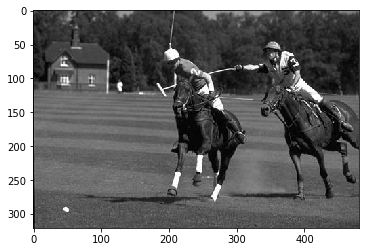

In [10]:
plt.imshow(image)

In [11]:
#mask=gaussianFilter(5,30)

In [12]:
#plt.imshow(mask)
def padding1(image,filtersize):
    imagesize=image.shape
    p=(filtersize-1)//2
    a=np.zeros((imagesize[0]+2*p,imagesize[1]+2*p))
    a[p:p+imagesize[0],p:p+imagesize[1]]=np.copy(image[:,:])
    return a

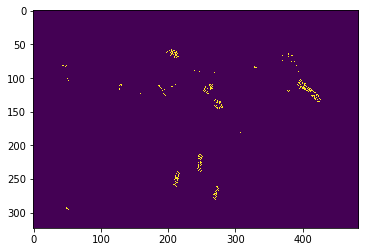

In [13]:
gray=rgbToGrayForFilterSize(image,3)
gray=np.float32(gray)
plt.imshow(gray)

In [14]:
def sobel(image):
    dx,dy=np.zeros((image.shape[0]-2,image.shape[1]-2)),np.zeros((image.shape[0]-2,image.shape[1]-2))
    dx,dy=dx.astype(np.int64),dy.astype(np.int64)
    horiz=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    verti=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    horiz,verti=horiz.astype(np.int64),verti.astype(np.int64)
    for i in range(dx.shape[0]):
        for j in range(dx.shape[1]):
            dx[i][j]=np.sum(image[i:i+3,j:j+3]*horiz)
            dy[i][j]=np.sum(image[i:i+3,j:j+3]*verti)
    return [dx.astype(np.int64),dy.astype(np.int64)]

In [15]:
[dx,dy]=sobel(gray)
Magni=np.sqrt(dx*dx+dy*dy)

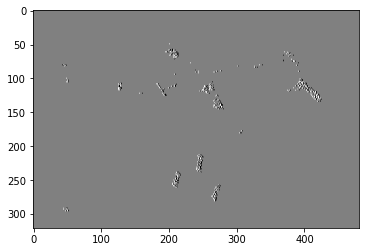

In [16]:
plt.imshow(dx,cmap='gray')

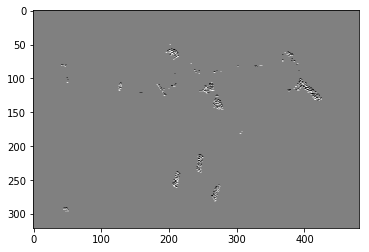

In [17]:
plt.imshow(dy,cmap='gray')

In [18]:
def gradient_squares(dx, dy):
    dx_square = dx*dx
    dy_square = dy*dy
    dx_dy = dx*dy
    return dx_square, dy_square, dx_dy

In [19]:
def red_dots(image,x_axis,y_axis,i):
    plt.imshow(image)
    plt.plot([i for i in y_axis],[i for i in x_axis],'.',color="red")

In [20]:
def harris_corners(image):
    global threshold,alpha
    center = window_size//2
    numRows = image.shape[0]
    numCols = image.shape[1]
    cornerList = np.zeros(image.shape)
    harris_img = image.copy()
    [dx,dy]=sobel(image)
    count = 0;
    dx_square, dy_square, dx_dy = gradient_squares(dx, dy)
    for y in range(0, numRows-center):
        for x in range(0, numCols-center):
            windowIxx = dx_square[y-center:y+center+1, x-center:x+center+1]
            windowIxy = dx_dy[y-center:y+center+1, x-center:x+center+1]
            windowIyy = dy_square[y-center:y+center+1, x-center:x+center+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()
            Det = Sxx*Syy - (Sxy**2)
            Trace = Sxx + Syy
            f = Det - alpha*(Trace**2)
            #print(f)
            if f > threshold*100:
                count+=1;
                cornerList[y,x]=f
                
    print(count)
    return cornerList

In [21]:
def shi_tomasi_corners(image):
    global threshold,alpha
    center = window_size//2
    numRows = image.shape[0]
    numCols = image.shape[1]
    cornerList = np.zeros(image.shape)
    harris_img = image.copy()
    [dx,dy]=sobel(image)
    dx_square, dy_square, dx_dy = gradient_squares(dx, dy)
    for y in range(0, numRows-center):
        for x in range(0, numCols-center):
            windowIxx = dx_square[y-center:y+center+1, x-center:x+center+1]
            windowIxy = dx_dy[y-center:y+center+1, x-center:x+center+1]
            windowIyy = dy_square[y-center:y+center+1, x-center:x+center+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()
            hmatrix = [[Sxx,Sxy],[Sxy,Syy]]
            [lambda1,lambda2] = np.linalg.eigvals(hmatrix)
            #print([lambda1,lambda2])
            if min(lambda2,lambda1) > threshold*350:
                cornerList[y,x]=min(lambda1,lambda2)
                
    return cornerList  

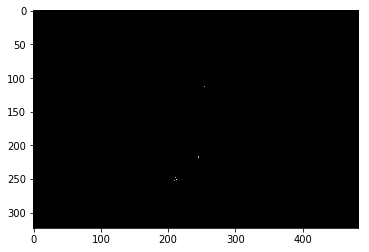

In [22]:
img1 = shi_tomasi_corners(gray)
[dx1,dy1]=sobel(img1)
Magni1=np.sqrt(dx1*dx1+dy1*dy1)
plt.imshow(img1, cmap='gray')

In [23]:
img = harris_corners(gray)


2871


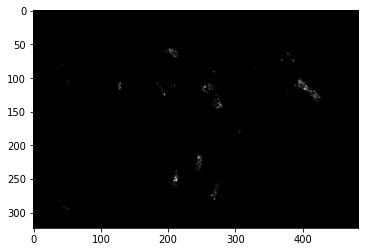

In [24]:
plt.imshow(img, cmap="gray")

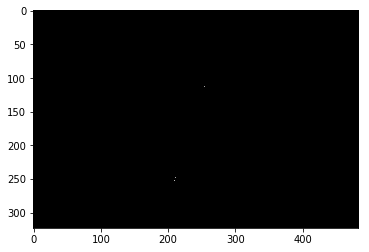

In [25]:
vam1,x1,y1,i = nonMaxSupression(img1,3)
plt.imshow(vam1,cmap='gray')

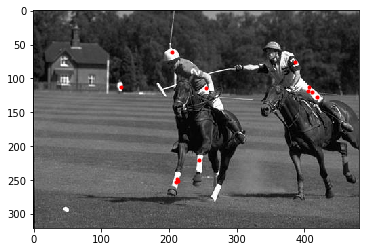

In [26]:
vam1,x1,y1,i = nonMaxSupression(img1,3)
red_dots(image,x1,y1,i)

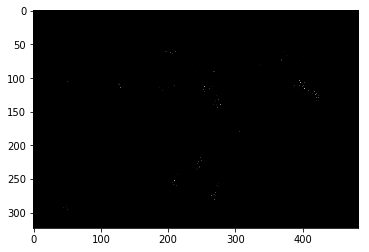

In [27]:
vam2,x2,y2,i2 = nonMaxSupression(img,3)
plt.imshow(vam2,cmap='gray')

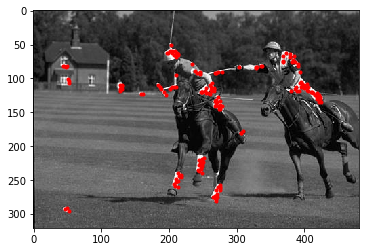

In [28]:
vam2,x2,y2,i2 = nonMaxSupression(img,3)
red_dots(image,x2,y2,i)